# Install and import required packages

In [1]:
!pip install -q -U grain clu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.5/494.5 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 5.9 MB/s eta 0:00:00


In [ ]:
import os
import sys

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

'''
    Uncomment the line bellow to simulate 8 devices when running on CPU.
'''
flags = os.environ.get("XLA_FLAGS", "")
flags += " --xla_force_host_platform_device_count=8"  # Simulate 8 devices
os.environ["XLA_FLAGS"] = flags

import jax
from jax import numpy as jnp
from flax import linen as nn
from flax.training import train_state
from flax.training.common_utils import shard, shard_prng_key, get_metrics
import optax
import numpy as np
import grain.python as grain
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ml_collections
from tqdm.auto import tqdm
from clu import metric_writers
import orbax.checkpoint as ocp
from tokenizers import ByteLevelBPETokenizer
import nltk

import pathlib
import requests
import zipfile

prng_main_key = jax.random.key(18)

print(f"Jax Device count: {jax.device_count()}")

Jax Device count: 8


In [28]:
!ls

dataset  sample_data


In [ ]:
# Import custom files

# Download the code to the current working directory
REPO_NAME = 'transformer-from-scratch'
if not os.path.isdir(REPO_NAME):
    !git clone https://github.com/MiguelSteph/transformer-from-scratch.git

%run 'transformer-from-scratch/configs/configs.py'
%run 'transformer-from-scratch/dataset_utils.py'
%run 'transformer-from-scratch/tokenizer.py'
%run 'transformer-from-scratch/models.py'
%run 'transformer-from-scratch/train_and_eval_utils.py'


config = get_configs()

# Download the dataset
We will use the french to english dataset.
It can be downloaded at https://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip

In [19]:
download_data(config)

# Build BPE tokenizer
In the first version of the project, I used the tiktoken tokenizer. Since we have a small dataset, I noticed the the number of token is too much and the model has some issue to increase its accuracy.
I switched to creating a custom tokenizer.

In [30]:
if not os.path.exists(config.trg_tokenizer_path + '/vocab.json'):
    build_and_save_tokenizer(config)
else:
    print("Tokenizer is already built.")

# Load saved tokenizer
fr_tokenizer = ByteLevelBPETokenizer(config.trg_tokenizer_path + '/vocab.json', config.trg_tokenizer_path + '/merges.txt')
en_tokenizer = ByteLevelBPETokenizer(config.src_tokenizer_path + '/vocab.json', config.src_tokenizer_path + '/merges.txt')
fr_tokenizer.add_special_tokens(config.tokenizer_special_tokens)
en_tokenizer.add_special_tokens(config.tokenizer_special_tokens)

Tokenizer is already built.


3

# Data exploration
We will explore the following aspect of the dataset:
* overall number of sample in the dataset
* Number of unique sentences both in english and french
* Number of tokens distribution both in english and french

The exploration has the following two goals:
* Determine the correct max sequence length for the model
* Better slit the dataset into train, validation and test sets. We don't want to include the same sentences into training and validation/test sets.

Dataset size is 167130
Number of unique french sentences is 158527 which is 94%
Number of unique english sentences is 116830 which is 69%
Max token length for french sentences is 90
Max token length for english sentences is 69


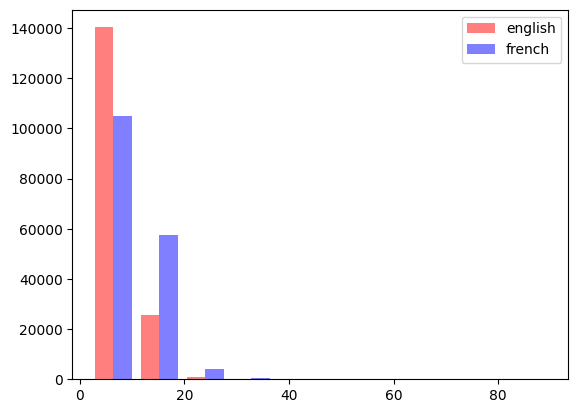

In [32]:
fr_sentences = []
en_sentences = []

with open(config.dataset_path) as f:
    lines = f.read().split('\n')
    for line in lines:
        line_split = line.split('\t')
        if len(line_split) == 2:
            fr_sentences.append(line_split[1].strip())
            en_sentences.append(line_split[0].strip())

dataset_size = len(en_sentences)
distinct_fr_sentences = len(set(fr_sentences))
distinct_en_sentences = len(set(en_sentences))

fr_distinct_percentage = (distinct_fr_sentences * 100) // dataset_size
en_distinct_percentage = (distinct_en_sentences * 100) // dataset_size


print(f"Dataset size is {dataset_size}")
print(f"Number of unique french sentences is {distinct_fr_sentences} which is {fr_distinct_percentage}%")
print(f"Number of unique english sentences is {distinct_en_sentences} which is {en_distinct_percentage}%")




# Token distribution
fr_tokens_len = [len(fr_tokenizer.encode(sentence).ids) for sentence in fr_sentences]
en_tokens_len = [len(en_tokenizer.encode(sentence).ids) for sentence in en_sentences]

print(f"Max token length for french sentences is {max(fr_tokens_len)}")
print(f"Max token length for english sentences is {max(en_tokens_len)}")

plt.hist([en_tokens_len, fr_tokens_len], color=['r', 'b'], label=['english', 'french'], alpha=0.5)
plt.legend()
plt.show()

del fr_sentences
del en_sentences
del distinct_fr_sentences
del distinct_en_sentences
del dataset_size
del fr_distinct_percentage
del en_distinct_percentage
del fr_tokens_len
del en_tokens_len

**Takeaways:**
* only 69% of the english sentences are distincts. We need to be careful when creating the validation and test sets.
* We will set the max token length for french sentences to **120**.
* We will set the max token length for english sentences to **60**.

# Dataset preparation
Here we will split the dataset into three sets: training, validation and test set. The test and validation set will represent each **10%** of the unique sentences and the training set will represent the remaining data.

In [ ]:
prng_main_key, data_preparation_prng = jax.random.split(prng_main_key, 2)
train_loader, val_loader, test_loader = load_and_prepare_dataset(en_tokenizer, 
                                                                 fr_tokenizer,
                                                                 config.dataset_path, 
                                                                 data_preparation_prng, 
                                                                 num_epochs=config.training_epochs, 
                                                                 train_batch_size=config.batch_size, 
                                                                 test_or_val_batch_size=config.batch_size,
                                                                 max_src_len=config.max_src_len,
                                                                 max_trg_len=config.max_trg_len)


# Model

For this tutorial, we want to implement from scratch the [original transformer model](https://arxiv.org/abs/1706.03762) with Jax.
<!-- ![Model architecture](https://arxiv.org/html/1706.03762v7/Figures/ModalNet-21.png) -->

In this tutorial, we will focus on the implementation part. We will start our journey with the positional encoding component.

## Positional encoding
The positional encoding module is the module that add encode the position of the word in the model. Same as the original paper, we will use a static positonal encoding computed based on the following formular:

***TODO: Add an image of the formular.***

## Multi-head attention module

The central piece of the multi-heat attention layer is the scaled dot product attention.

## Feed-forward component
The Feed forward component consists of two linear transformations with a ReLU activation function in between. We will create a module for that as well.

## Add&Norm module
This layer takes as input the output of a sub layer and a residual connection. It applies a dropout to the output of the previous sublayer and add that to the residual connection. It finally normalizes the result. We will a layer normalization module here instead of the batch naormalization layer used in the original paper.

In [ ]:
# Testing model components

test_num_heads = 8
test_d_proj = 32
test_use_causal_mask= True
test_emb_dim = 256
test_src_len= 60
test_batch_size = 32
test_d_inner = 1024
test_dropout = 0.2
test_num_blocks = 6
test_ff_d_inner = 512
test_max_vocab_size = 5000
max_seq_len = 64

test_prng_key = jax.random.key(44)
key_1, key_2, key_3, key_4, key_5, dropout_key = jax.random.split(test_prng_key, 6)


# Test the positional encoding module
test_random_input = jax.random.normal(test_prng_key, (config.batch_size, config.max_trg_len, config.emb_dim))

test_pos_enc_module = PositionalEncoding(config.emb_dim, config.max_trg_len)
variables = test_pos_enc_module.init(test_prng_key, test_random_input)
x = test_pos_enc_module.apply({}, test_random_input)

# Expect the input shape to be the same as the output shape
print("Testing positional encoding module")
print(f"Input shape: {test_random_input.shape}")
print(f"Output shape: {x.shape}")
print()



# Test multi head attention layer shape output
test_multi_head_att_module = MultiHeadAttentionModule(test_num_heads, 
                                                      test_emb_dim, 
                                                      test_d_proj, 
                                                      test_d_proj, 
                                                      use_causal_mask=True)
k = jax.random.normal(key_1, (test_batch_size, test_src_len, test_emb_dim))
v = jax.random.normal(key_2, (test_batch_size, test_src_len, test_emb_dim))
q = jax.random.normal(key_3, (test_batch_size, test_src_len, test_emb_dim))
sample_mask = jax.random.choice(key_3, 2, (test_batch_size, test_src_len))

variables = test_multi_head_att_module.init(test_prng_key, k, v, q)
params = variables['params']

attentions = test_multi_head_att_module.apply({'params': params}, k, v, q, mask=sample_mask)
print("Testing multi head attention module")
print(f"Expected shape: {(test_batch_size, test_src_len, test_emb_dim)}")
print(f"Actual shape: {attentions.shape}")
print()



# Test Feedforward module
sample_input = jax.random.normal(key_1, (test_batch_size, test_src_len, test_emb_dim))

test_ff_module = FeedForwardModule(test_d_inner, test_emb_dim)
variables = test_ff_module.init(key_2, sample_input)

test_output = test_ff_module.apply(variables, sample_input)
print("Testing Feedforward module")
print(f"Expected output shape: {(test_batch_size, test_src_len, test_emb_dim)}")
print(f"Actual output shape: {test_output.shape}")
print()


# Test Add&Norm module
sample_x = jax.random.normal(key_1, (test_batch_size, test_src_len, test_emb_dim))
sample_residual_x = jax.random.normal(key_2, (test_batch_size, test_src_len, test_emb_dim))

test_add_norm_module = AddAndNormModule(test_dropout)
variables = test_add_norm_module.init(key_3, sample_x, sample_residual_x, training=True)

test_output = test_add_norm_module.apply(variables, 
                                         sample_x, 
                                         sample_residual_x, 
                                         training=True, 
                                         rngs={'dropout': dropout_key})
print("Testing Add&Norm module")
print(f"Expected output shape: {(test_batch_size, test_src_len, test_emb_dim)}")
print(f"Actual output shape: {test_output.shape}")
print()



# Test Encoder block module 
sample_mask = jax.random.choice(key_1, 2, (test_batch_size, test_src_len))
sample_x = jax.random.normal(key_2, (test_batch_size, test_src_len, test_emb_dim))

test_encoder_block_module = EncoderBlockModule(test_d_inner, test_emb_dim, 
                                               test_dropout, test_num_heads, test_d_proj)
variables = test_encoder_block_module.init(key_3, sample_x)
test_output = test_encoder_block_module.apply(variables, sample_x, 
                                              mask=sample_mask, training=True, 
                                              rngs={'dropout': dropout_key})
print("Testing Encoder block module")
print(f"Expected output shape: {(test_batch_size, test_src_len, test_emb_dim)}")
print(f"Actual output shape: {test_output.shape}")
print()



# Test Decoder block module 
sample_mask = jax.random.choice(key_1, 2, (test_batch_size, test_src_len))
sample_x = jax.random.normal(key_2, (test_batch_size, test_src_len, test_emb_dim))
sample_enc_output = jax.random.normal(key_3, (test_batch_size, test_src_len, test_emb_dim))

test_decoder_block_module = DecoderBlockModule(test_d_inner, test_emb_dim, 
                                               test_dropout, test_num_heads, test_d_proj)
variables = test_decoder_block_module.init(key_4, sample_x, sample_enc_output)
test_output = test_decoder_block_module.apply(variables, sample_x, sample_enc_output, 
                                              mask=sample_mask, training=True, 
                                              rngs={'dropout': dropout_key})
print("Testing Decoder block module")
print(f"Expected output shape: {(test_batch_size, test_src_len, test_emb_dim)}")
print(f"Actual output shape: {test_output.shape}")
print()



# Test transformer output shape
sample_enc_mask = jax.random.choice(key_1, 2, (test_batch_size, test_src_len))
sample_dec_mask = jax.random.choice(key_2, 2, (test_batch_size, test_src_len))
sample_enc_x = jax.random.choice(key_3, test_max_vocab_size, (test_batch_size, test_src_len))
sample_dec_x = jax.random.choice(key_4, test_max_vocab_size, (test_batch_size, test_src_len))

test_transformer_module = TransformerModule(test_num_blocks, test_ff_d_inner, 
                                            test_emb_dim, test_dropout, 
                                            test_num_heads, test_d_proj, 
                                            test_max_vocab_size, max_seq_len)
variables = test_transformer_module.init(key_5, sample_enc_x, sample_dec_x)
test_output = test_transformer_module.apply(variables, sample_enc_x, sample_dec_x, 
                                            sample_enc_mask, sample_dec_mask, 
                                            training=True, rngs={'dropout': dropout_key})

print("Testing Full transformer module")
print(f"Expected output shape: {(test_batch_size, test_src_len, test_max_vocab_size)}")
print(f"Actual output shape: {test_output.shape}")

# Training
## Visualize learning rate
We have a learning rate decay function that slowly warm up the learning rate to a base learning rate and then applies cosine decay to it for the rest of the training.

In [ ]:
base_lr=0.01
warmup_epochs=2
cosine_epochs=8
steps_per_epochs=1000

steps = list(range(10000))
scheduler = create_learning_rate_scheduler(base_lr, warmup_epochs, 
                                           cosine_epochs, steps_per_epochs)
lr_val = [scheduler(step) for step in range(10000)]

fig,ax=plt.subplots(figsize=(12, 4))
ax.plot(steps, lr_val)
ax.grid()
ax.set(xlabel='Steps', ylabel='Learning rate')
plt.show()

## Training

In [ ]:
parallel_train_step = jax.pmap(train_step, axis_name="batch", donate_argnums=(0,))
parallel_eval_step = jax.pmap(eval_step, axis_name="batch")

def train_and_evaluate(param_init_prng_key, dropout_key, config, train_loader, val_loader):
    writer = metric_writers.create_default_writer(config.metric_path)
    ckp_options = ocp.CheckpointManagerOptions(max_to_keep=3, 
                                               save_interval_steps=1, 
                                               best_fn= lambda metrics: metrics['acc'])
    ckp_mngr = ocp.CheckpointManager(os.path.abspath(config.checkpoint_path), options=ckp_options)

    train_loader_iter = iter(train_loader)
    state = create_train_state(config, param_init_prng_key, dropout_key)

    # Replicate the train state for pmap
    state = flax.jax_utils.replicate(state)
    state = state.replace(dropout_key=shard_prng_key(dropout_key))
    
    for epoch in range(config.training_epochs):
        print(f"\nTraining Epoch {epoch + 1}\n")
        acc_vals = jnp.array([])
        loss_vals = jnp.array([])
        with tqdm(total=config.steps_per_epochs, desc=f"Training Epoch {epoch}", leave=False) as progress_bar_train:
            for step in tqdm(range(config.steps_per_epochs)):
                train_batch = next(train_loader_iter)
                train_batch = shard(train_batch)
                
                state, batch_metrics = parallel_train_step(state, train_batch)
                acc_vals = jnp.concatenate([acc_vals, batch_metrics['acc'][:1]])
                loss_vals = jnp.concatenate([loss_vals, batch_metrics['loss'][:1]])
                progress_bar_train.update(1)

            for step in range(config.steps_per_epochs):
                writer.write_scalars(step, {'acc': acc_vals[step], 'loss': loss_vals[step]})
            progress_bar_train.write(f"Training Epoch {epoch} End => accuracy: {batch_metrics['acc'][0]}    Loss: {batch_metrics['loss'][0]}")

        print(f"\nEval epoch {epoch + 1}")
        eval_acc_vals = jnp.array([])
        eval_loss_vals = jnp.array([])
        val_loader_iter = iter(val_loader)
        with tqdm(total=config.val_steps, desc=f"Validation Epoch {epoch}", leave=False) as progress_bar_validation:
            for val_step in tqdm(range(config.val_steps)):
                val_batch = next(val_loader_iter)
                val_batch = shard(val_batch)
                
                val_metrics = parallel_eval_step(state, val_batch)
                eval_acc_vals = jnp.concatenate([eval_acc_vals, val_metrics['acc'][:1]])
                eval_loss_vals = jnp.concatenate([eval_loss_vals, val_metrics['loss'][:1]])
                progress_bar_validation.update(1)
            progress_bar_validation.write(f"Validation Epoch {epoch + 1} => accuracy: {jnp.mean(eval_acc_vals)}    Loss: {jnp.mean(eval_loss_vals)}")

        ckp_mngr.save(epoch,
              args=ocp.args.StandardSave(flax.jax_utils.unreplicate(state)),
              metrics={'acc': float(jnp.mean(eval_acc_vals)), 'loss': float(jnp.mean(eval_loss_vals))})
    
    ckp_mngr.wait_until_finished()
    
    return state


state = train_and_evaluate(param_init_prng_key, dropout_key, config, train_loader, val_loader)

# Inference

In [ ]:
fr_tokenizer = ByteLevelBPETokenizer(config.trg_tokenizer_path + '/vocab.json', config.trg_tokenizer_path + '/merges.txt')
en_tokenizer = ByteLevelBPETokenizer(config.src_tokenizer_path + '/vocab.json', config.src_tokenizer_path + '/merges.txt')
fr_tokenizer.add_special_tokens(config.tokenizer_special_tokens)
en_tokenizer.add_special_tokens(config.tokenizer_special_tokens)

model = create_model(config)
ckp_options = ocp.CheckpointManagerOptions(max_to_keep=3, 
                                       save_interval_steps=1, 
                                       best_fn= lambda metrics: metrics['acc'])
ckp_mngr = ocp.CheckpointManager('/kaggle/input/result/results/checkpoints', options=ckp_options)
restored_state = ckp_mngr.restore(step=None, args=ocp.args.StandardRestore())

# Test
src_sentence = 'Thank God'
translation_text = run_inference(src_sentence, config, model, restored_state['params'], en_tokenizer, fr_tokenizer)
print(translation_text)
    

## Bleu score

In [ ]:
en_sentences = []
fr_translations = []
for sample in test_loader:
    for idx in range(sample['src_tokens'].shape[0]):
        en_sentence = en_tokenizer.decode(sample['src_tokens'][idx])
        fr_translation = fr_tokenizer.decode(sample['trg_input_tokens'][idx])
        # model_translation = run_inference(original_sentence, config, model, restored_state['params'], en_tokenizer, fr_tokenizer)
        en_sentences.append(en_sentence)
        fr_translations.append(fr_translation)
        # model_translations.append(model_translation)

# Randomnly pick 200 sentences for BLEU score computation
indices = jax.random.choice(prng_main_key, len(en_sentences), (200,))
bleu_en_sentences = [en_sentences[x] for x in indices]
bleu_fr_original_transaltion = [fr_translations[x] for x in indices]
model_translations = []
for idx in range(200):
    translation = run_inference(bleu_en_sentences[idx], config, model, restored_state['params'], en_tokenizer, fr_tokenizer)
    model_translations.append(translation)

In [ ]:
candidates = [x.split() for x in model_translations]
references = [x.split() for x in bleu_fr_original_transaltion]
bleu_scores = []


for idx in range(200):
    score = nltk.translate.bleu_score.sentence_bleu([references[idx]], candidates[idx])
    bleu_scores.append(score)
bleu_score = sum(bleu_scores) / len(bleu_scores)
print(bleu_score)